In [1]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# data transforamtion and manipulation
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(precision=5, suppress=True)


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# plotting and plot styling
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
#sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"


# statistical modeling libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
#from arch import arch_model


# deep learning
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model 


# jupyter wdgets
from ipywidgets import interactive, widgets, RadioButtons, ToggleButtons, Select, FloatSlider, FloatProgress
from IPython.display import set_matplotlib_formats, Image

Using TensorFlow backend.


# 5. ARIMA Forecasting

An autoregressive integrated moving average (ARIMA) model is an generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity. - <a href="https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average">Wikipedia</a>

In the base model there are three parameters $(p, d, q)$ that are used to parametrize ARIMA models. Hence, an ARIMA model is denoted as $ARIMA(p, d, q)$ and is defined by

$$
\left(1 - \sum_{i=1}^p \phi_i L^i \right) (1 - L)^d y_t = \mu + \left(1 + \sum_{i=1}^q \theta_i L^i \right) \varepsilon_t
$$

where $L$ denotes the <strong>lag operator</strong>. THe lag operator performs a lagged transformation fo a variable with time index like $y_t L^d = y_{t-d}$. Each of these three parts is an effort to make the time series stationary, i. e. make the final residual a white noise pattern. 

A good resource for a quick mathematical overview of the ARIMA model is given <a href="http://users.dma.unipi.it/~flandoli/AUTCap4.pdf">here</a>.



## 5.1 Box-Jenkins Approach to non-Seasonal ARIMA Modeling

In time series analysis, the Box–Jenkins method,[1] named after the statisticians George Box and Gwilym Jenkins, applies autoregressive moving average (ARMA) or autoregressive integrated moving average (ARIMA) models to find the best fit of a time-series model to past values of a time series.

The original model uses an iterative three-stage modeling approach:

1. **Model identification** and model selection: making sure that the variables are stationary, identifying seasonality in the dependent series (seasonally differencing it if necessary), and using plots of the autocorrelation and partial autocorrelation functions of the dependent time series to decide which (if any) autoregressive or moving average component should be used in the model.
2. **Parameter** estimation using computation algorithms to arrive at coefficients that best fit the selected ARIMA model. The most common methods use maximum likelihood estimation or non-linear least-squares estimation.
3. **Model checking** by testing whether the estimated model conforms to the specifications of a stationary univariate process. In particular, the residuals should be independent of each other and constant in mean and variance over time. (Plotting the mean and variance of residuals over time and performing a Ljung–Box test or plotting autocorrelation and partial autocorrelation of the residuals are helpful to identify misspecification.) If the estimation is inadequate, we have to return to step one and attempt to build a better model.
The data they used were from a gas furnace. These data are well known as the Box and Jenkins gas furnace data for benchmarking predictive models.

Commandeur & Koopman (2007, §10.4)[2] argue that the Box–Jenkins approach is fundamentally problematic. The problem arises because in "the economic and social fields, real series are never stationary however much differencing is done". Thus the investigator has to face the question: how close to stationary is close enough? As the authors note, "This is a hard question to answer". The authors further argue that rather than using Box–Jenkins, it is better to use state space methods, as stationarity of the time series is then not required.

In [4]:
# load passenger data set and save to DataFrame
df = pd.read_csv('./data/passengers.csv', header=0, index_col=0, parse_dates=True, sep=';')

In [21]:
# split into training and test sets
y = df['n_passengers']
y_train = y[:'1958']
y_test = y['1959':]
y_test

month
1959-01-01    360
1959-02-01    342
1959-03-01    406
1959-04-01    396
1959-05-01    420
1959-06-01    472
1959-07-01    548
1959-08-01    559
             ... 
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: n_passengers, Length: 24, dtype: int64

## 5.2 Optimal Parameter Selection

To fit the time series data to a seasonal ARIMA model with parameters $ARIMA(p, d, q)(P, D, Q)s$ the optimal parameters need to be found first. This is done via <strong>grid search</strong>, the iterative exploration of all possible parameters constellations. Since there is no way of doing this automatically in Python we have to resort to doing this ourselves.

Depending on the size of the model parameters $(p, d, q)(P, D, Q)s$ this can become an extremely costly task with regard to computation. We start of by generating all possible parameter constellation we'd like to evaluate.

In [6]:
# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [7]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 0, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12)]

For all possible parameter constellations from both lists <code>pdq</code> and <code>seasonal_pdq</code> the alogrithm will create a model and eventually pick the best one to proceed. The best model is chosen based on the <strong>Akaike Information Criterion (AIC)</strong>. 

The Akaike information criterion (AIC) is a measure of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Hence, AIC provides a means for model selection. - <a href="https://en.wikipedia.org/wiki/Akaike_information_criterion">Wikipedia</a>

It measures the trade-off between the goodness of fit of the model and the complexity of the model (number of included and estimated aprameters). The AIC is calculated as follows

$$
AIC = 2k - 2ln(L)
$$

where $k$ corresponds to the number of estimated parameters in the model and $L$ refers to the maximum value of the likelihood function for the model. It is important to note that the AIC only measures the in-sample model fit of the data given for training.

In [57]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
            res = tmp_mdl.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        except:
            print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 1, 0)x(1, 2, 1, 12)12 model - AIC:821.9362038657893


The grid search found that the best model is a seasonal ARIMA model with <code>ARIMA(1, 1, 0)(1, 2, 1)12</code> for <code>y_test</code>. The SARIMAX model will be trained on the training data <code>y_train</code> udner the optimal parameter setting optained from the grid search. If the seasonal order is not given, the standard ARIMA model will be applied to the input data.

In [10]:
mdl = sm.tsa.statespace.SARIMAX(y_train,
                                order=(1, 1, 0),
                                seasonal_order=(1, 2, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
res = mdl.fit()

In [11]:
print(res.aic)
print(res.summary())

727.325689284
                                 Statespace Model Results                                 
Dep. Variable:                       n_passengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 0)x(1, 2, 1, 12)   Log Likelihood                -359.663
Date:                            Fri, 29 Sep 2017   AIC                            727.326
Time:                                    16:20:27   BIC                            738.476
Sample:                                01-01-1949   HQIC                           731.854
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3570      0.091     -3.909      0.000      -0.536      -0.178
ar.S.L12      -0.2319

The <code>summary</code> attribute that results from the output of SARIMAX returns a significant amount of information, but we'll focus our attention on the table of coefficients. The <code>coef</code> column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The <code>P>|z|</code> column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

The <strong>Ljung-Box Q statistic</strong> is used to test the $H_0$ that the complete data set is independently distributed, i.e. not serially correlated. The null is rejected if

$$
Q < \chi^2_{1-\alpha}(\nu)
$$

where the DoF $\nu = n - k$. Computing the critical value of the Chi-square distribution one finds that the resulting model exhibits serially uncorrelated errors:

In [84]:
from scipy.stats import chi2
chi = chi2.isf(q=0.05, df=116)
chi

142.13816003902645

The <strong>Jarque-Bera test</strong> is a goodness-of-fit test of whether the data has the skewness and kurtosis of a normal distribution. The normal distribution has a skew of 0 and a kurtosis of 3.

The <code>res</code> object has a convenient diagnostic method named <code>plot_diagnostics</code> method to get a rundown of the fitted model.

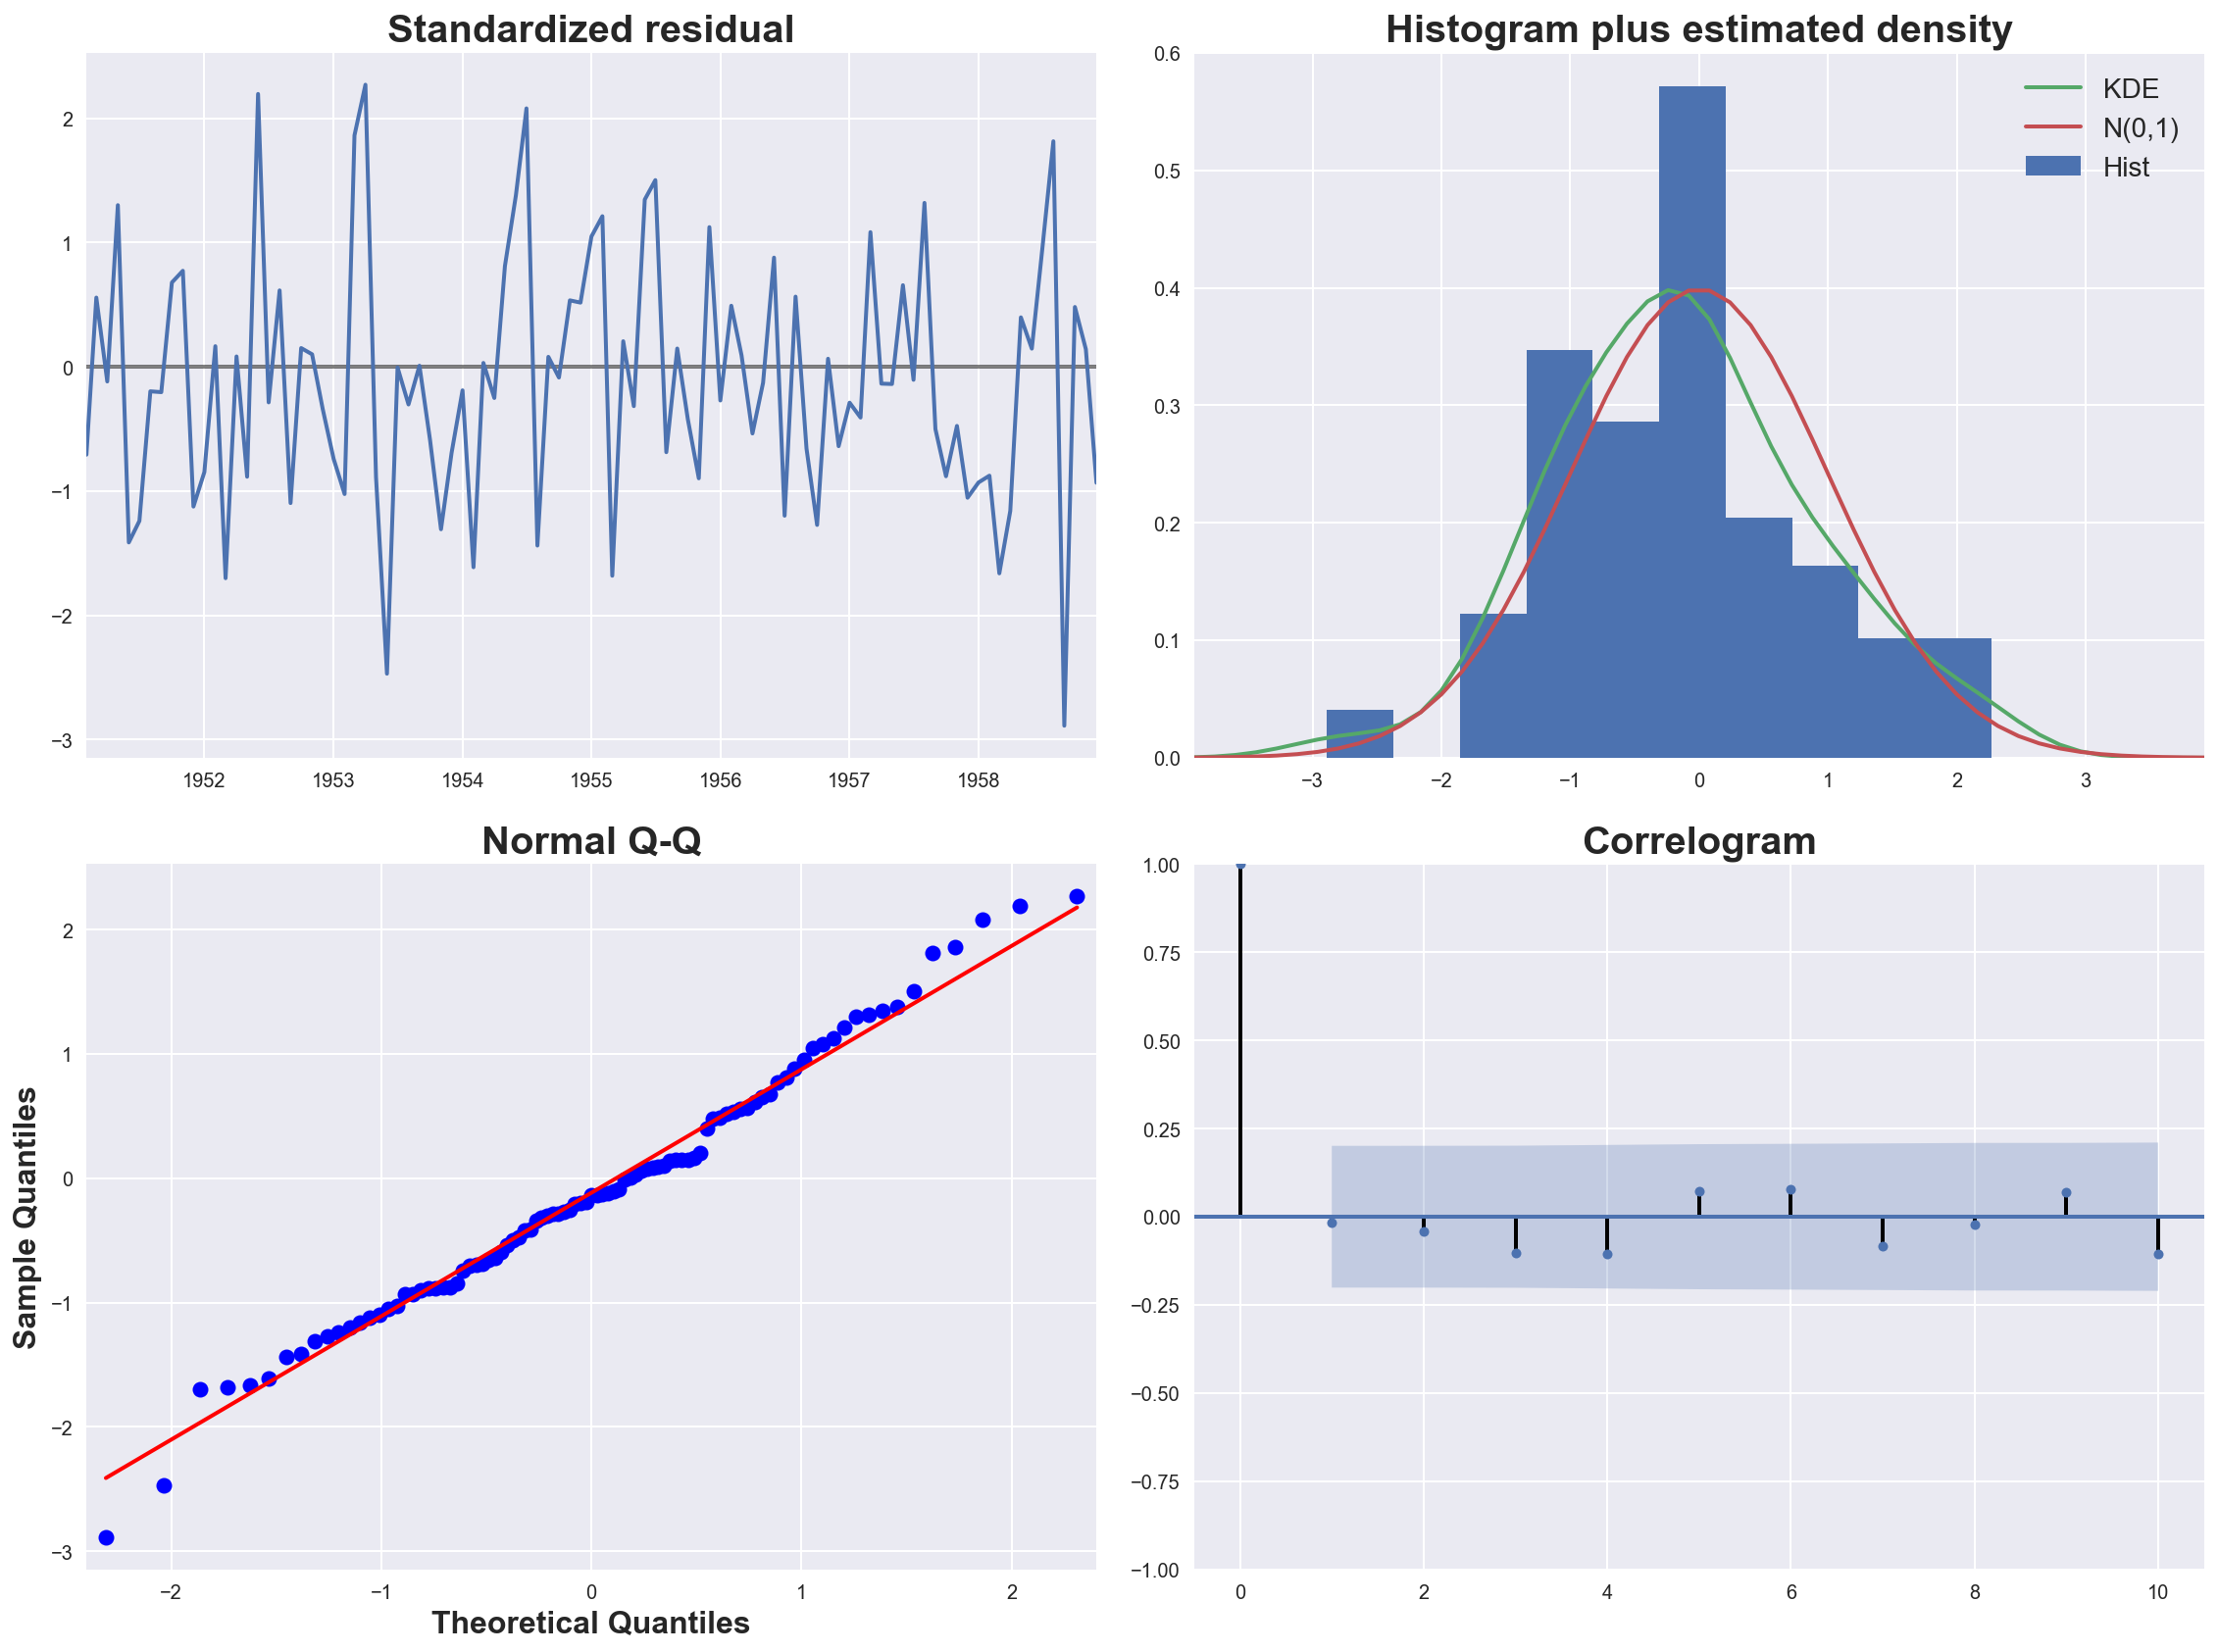

In [12]:
res.plot_diagnostics(figsize=(16, 12))
plt.tight_layout()
plt.show()

We need to ensure that the residuals of our model are dnormally distributed with zero-mean and not serially correlate, i. e. we'd like the remaining information to be white noise. If the fitted seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

<strong>Inference</strong>
<ul>
<li>The residual plot of the fitted model in the upper right corner appears do be white noise as it does not display obvious seasonality or trend behaviour.</li>
<li>The histogram plot in the upper right corner pair with the kernel density estimation (red line) indicates that the time series is almost normally distributed. This is compared to the density of the standard normal distribution (green line).</li>
<li>The correlogram (autocorrelation plot) confirms this resuts, since the time series residuals show low correlations with lagged residuals.</li>
</ul>

Judging from the plots, the residuals appear fairly normal with little information left in them. The model produces a satisfactory fit that describes the udnerlying time series data well enough to forecast future values. Although the fit so far appears to be fine, a better fit could be achieved with a more complex model, i.e. a better model might have been von when increasing the parameter space for the grid search.


## 5.4 One step ahead prediction

The <code>get_prediction</code> and <code>conf_int</code> methods calculate predictions for future points in time for the previously fitted model and the confidence intervals associated with a prediction, respectively. The <code>dynamic=False</code> argument causes the method to produce a <strong>one-step ahead prediction</strong> of the time series

In [13]:
pred = res.get_prediction(start=pd.to_datetime('1958-12-01'), 
                          end=pd.to_datetime('1960-12-01'),
                          dynamic=True)
pred_ci = pred.conf_int()

Then, the predicted values along with the corresponding confidence bound of the prediction and the original observations are plotted

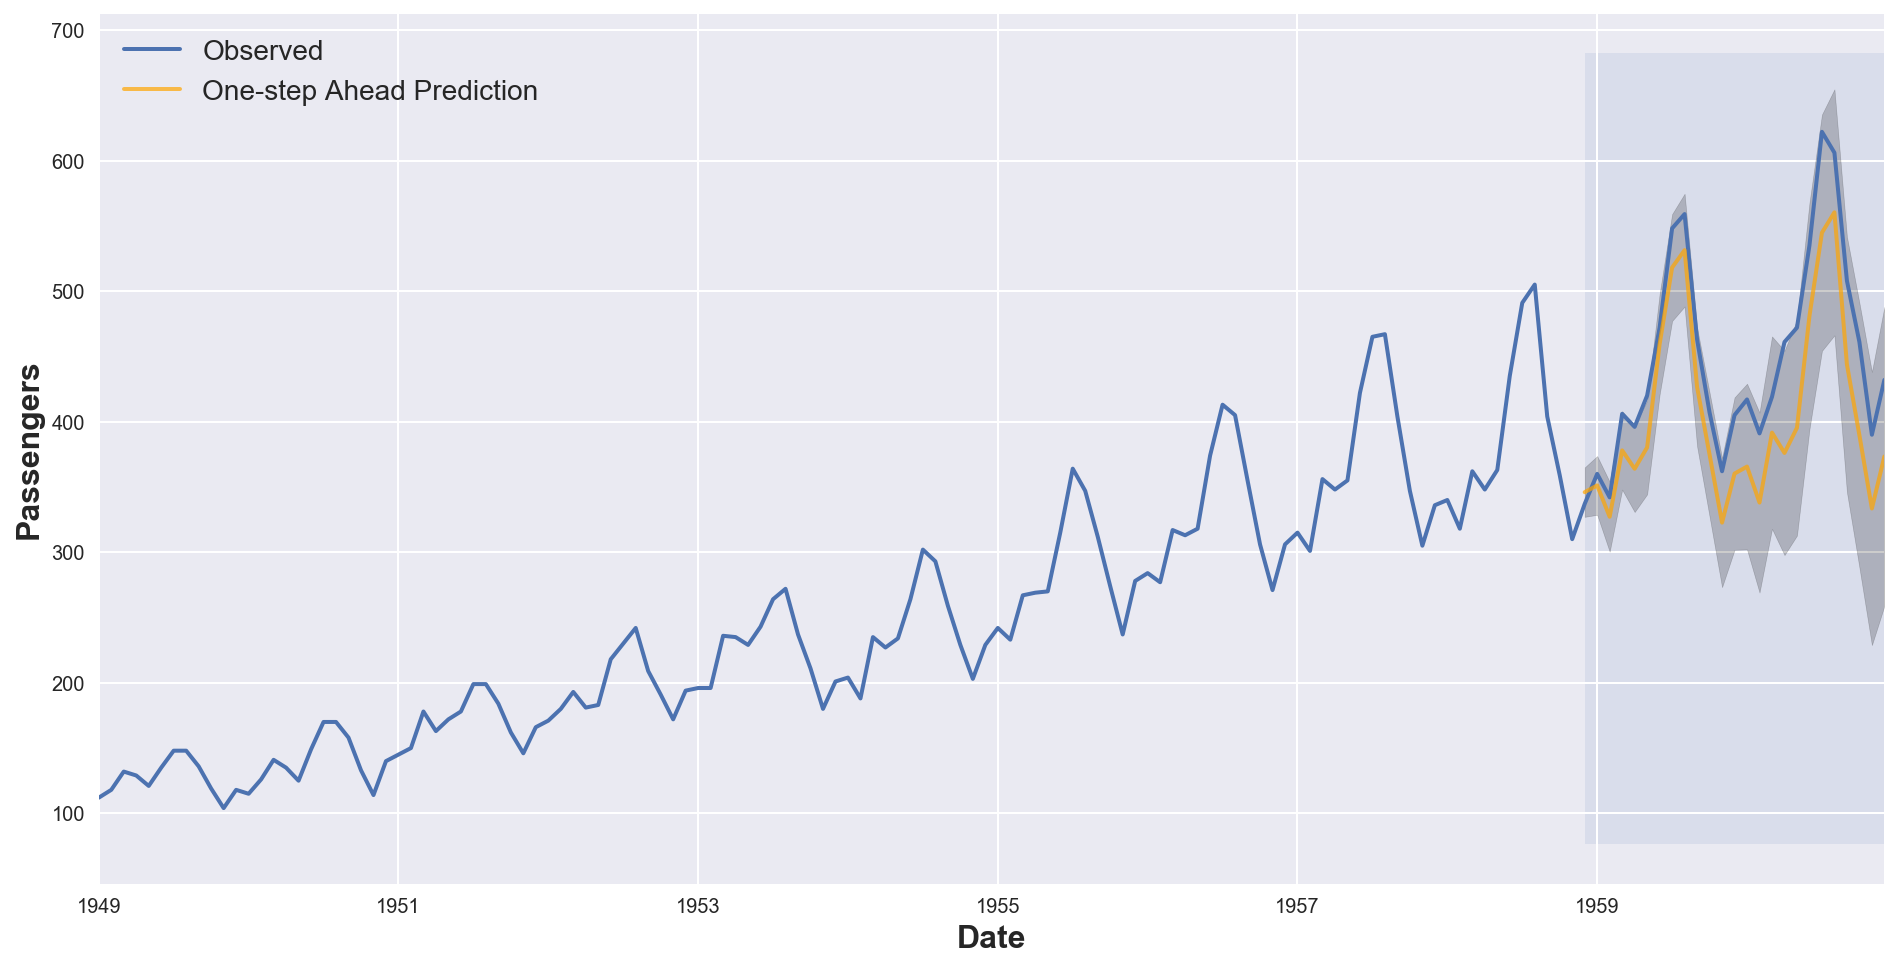

In [22]:
ax = y['1949':].plot(label='Observed');
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Prediction', alpha=.7, color='orange');

# draw confidence bound (gray)
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], color='k', alpha=.2);

# style the plot
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-12-01'), y.index[-1], alpha=.1, zorder=-1);
ax.set_xlabel('Date');
ax.set_ylabel('Passengers');
plt.legend(loc='upper left');

plt.show()

To quantify the accuracy between model fit and true observations wie will use the <strong>mean squared error</strong> (MSE). The MSE computes the squared difference between the true and predicted value.  The MSE is calculated as follows

$$
MSE = \frac{1}{T} \sum_{t=1}^T \left(\hat{y}_t - y_t \right)^2
$$

In [23]:
y_hat = pred.predicted_mean
y_true = y['1958-12-01':]

# compute the mean square error
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 2305.04 MSE (48.01 RMSE)


The one-step ahead prediction yielded a root mean square of 48.01, which appears reasonal comparing to the plot above for a prediction period of two years. This results imply, that on average, the prediction is off 48,010 passenger from the actual number of passengers.

## Out of sample prediction

To put the model to the real test with a 24-month-head prediction. This requires to pass the argument <code>dynamic=False</code> when using the <code>get_prediction</code> method.

In [24]:
pred_out = res.get_prediction(start=pd.to_datetime('1958-12-01'), 
                              end=pd.to_datetime('1960-12-01'), 
                              dynamic=False, full_results=True)
pred_out_ci = pred_out.conf_int()

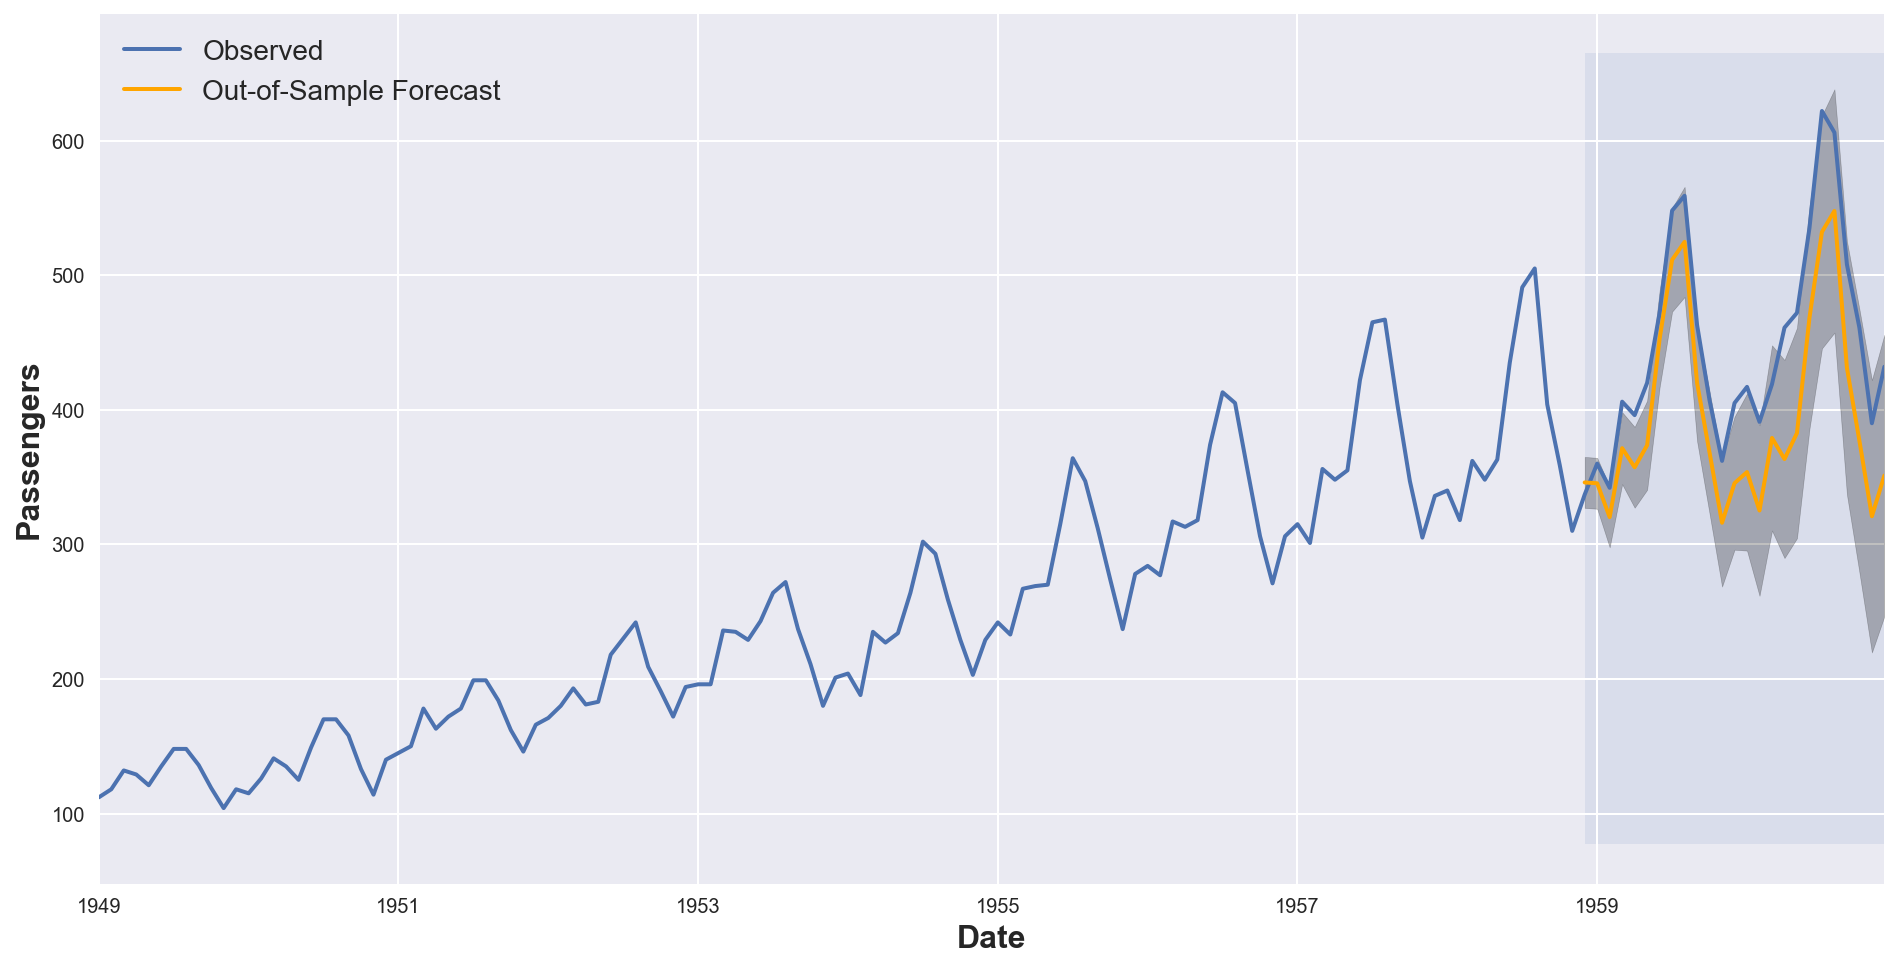

In [25]:
ax = y['1949':].plot(label='Observed')
pred_out.predicted_mean.plot(ax=ax, label='Out-of-Sample Forecast', color='orange')

ax.fill_between(pred_out_ci.index,
                pred_out_ci.iloc[:, 0],
                pred_out_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1958-12-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend()

plt.show()

It is obvious that, the further we try to extrapolate the time series evolution into the future, the less confident our prediction becomes. Hence, the confidence bound widens in the course of time. Moreover, we notic in the plot above that our model seems to systematically underestimate future values. It seems that there must have been a systematic pattern left in the time series which we were not able to extract with the seasonal ARIMA model.

Again, quantifying the accuracy of the prediction with the MSE criterion

In [26]:
# extract the predicted and true values of our time series
y_hat = pred_out.predicted_mean
y_true = y['1958-12-01':]

# compute the mean square error
mse = ((y_hat - y_true) ** 2).mean()
print('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))

Prediction quality: 3406.72 MSE (58.37 RMSE)


The prediction accuracy is lower than before. This is not only on account of the longer forecast horizon but also based on the fact that the constructed model only assumes an autoregressive order of 1. This means that predictions into the future rely on the last observation with $\phi = -0.3570$ implying that when predicted the second future value, the prediction relies only on the value of the previous period which itself is a forecast.

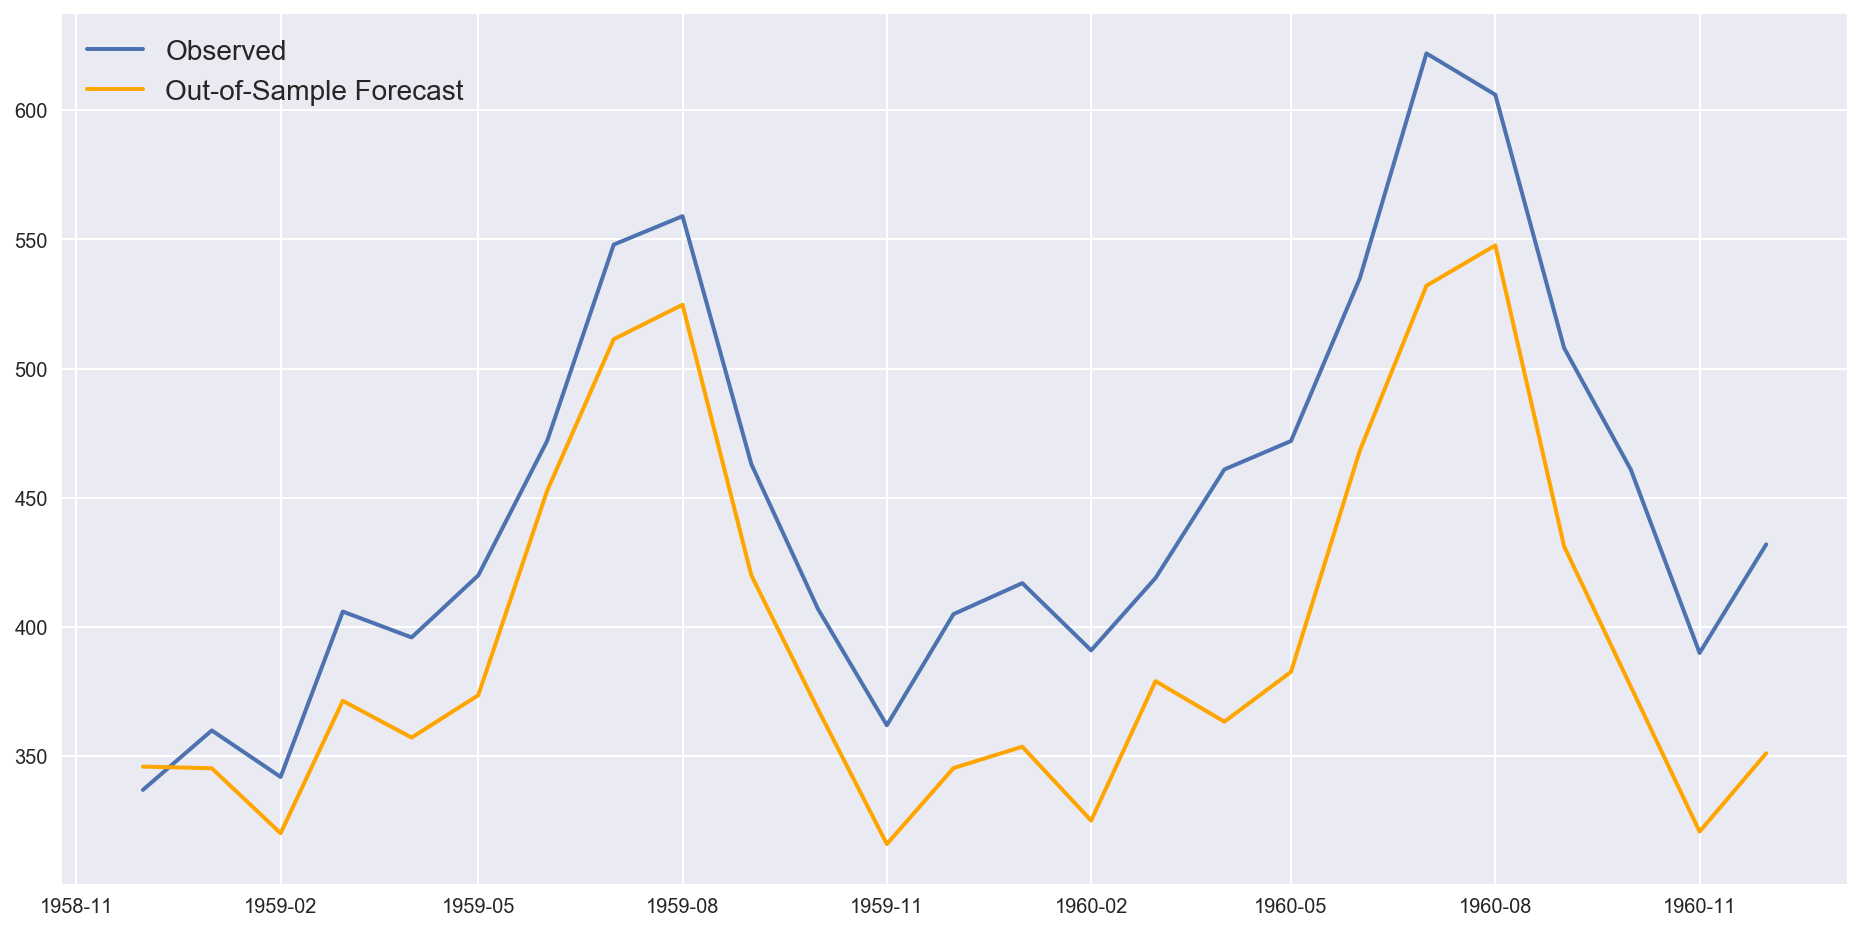

In [27]:
plt.plot(y_true, label='Observed')
plt.plot(y_hat, label='Out-of-Sample Forecast', color='orange')
ax.set_xlabel('Date')
ax.set_ylabel('Passengers')
plt.legend(loc='upper left');
plt.show()

## Long term forecasting

Finally, a 10 year ahead forecast, leverageing a seasonal ARIMA model trained on the complete time series <code>y</code>. Grid search found the best model to be of form <code>SARIMAX(2, 1, 3)(1, 2, 1)12</code> for the data vector <code>y</code>.

In [28]:
mdl = sm.tsa.statespace.SARIMAX(y,
                                order=(2, 1, 3),
                                seasonal_order=(1, 2, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
res = mdl.fit()

C:\Users\DEDACAT1\AppData\Local\conda\conda\envs\python35\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


and invoking the <code>get_prediction</code> method on <code>res</code> object

In [29]:
# get forecast 120 steps ahead in future
pred_uc = res.get_forecast(steps=120)

# get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

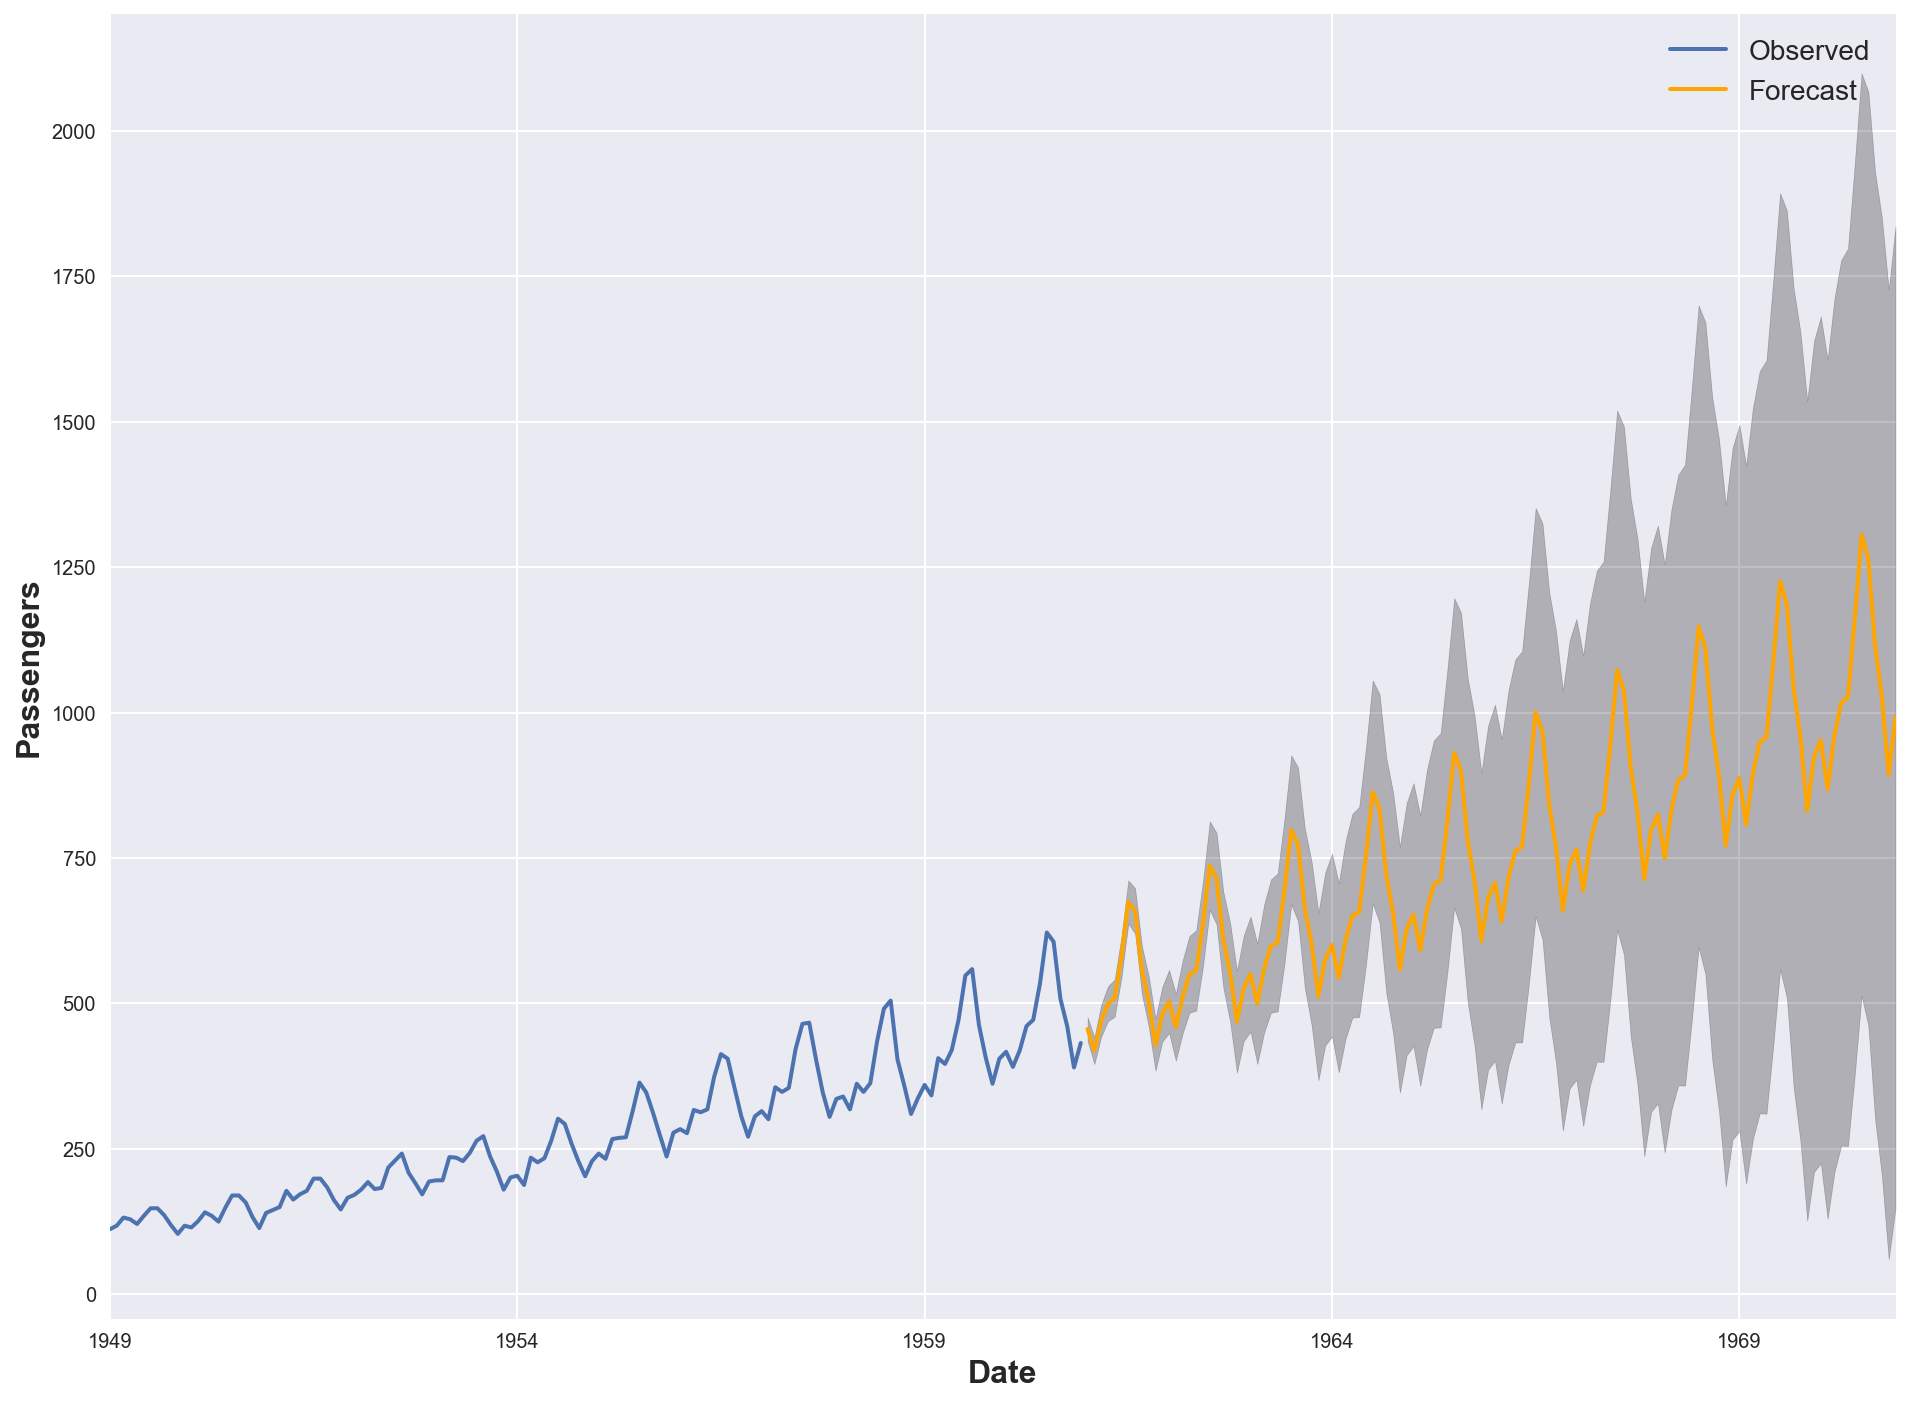

In [30]:
ax = y.plot(label='Observed', figsize=(16, 12));
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='orange');
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Passengers');

plt.legend();
plt.show()

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. The forecast shows that the time series is expected to continue increasing at a steady pace. Moreover, the seasonal magnitude is expected to grow over the years also.

As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

